In this tutorial we learn how to use the tf.esimator API to train a wide linear model and a deep feed-forward neutal network. This approach combines the strengths of memorization and generalization.

![wide and deep model](wide_n_deep.svg)

The explaination of the model from tensorflow website as following:

The figure above shows a comparison of a wide model (logistic regression with sparse features and transformations), a deep model (feed-forward neural network with an embedding layer and several hidden layers), and a Wide & Deep model (joint training of both). At a high level, here are the steps using the tf.estimator API:

1. Preprocess our movielens dataset in pandas.
2. Define features
3. Build inputs from the original dataset 
4. Hash string type categorical features and use int type features value as category id directly.
5. Create embeddings of sparse features for the deep model.
6. Define features for both the deep and the wide part of the model.
7. Train and validate the model.

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### 1. data preprocessing

load dataset and split train and valid set. This is same step we have shown in the previous notebook for collaborative filtering.

In [2]:
def load_movie_lens():
    age_desc = {
        1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"
    }
    occupation_desc = { 
        0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
        4: "college/grad student", 5: "customer service", 6: "doctor/health care",
        7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
        12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
        17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer"
    }
    rating_data = pd.read_csv(
        "ml-1m/ratings.dat",
        sep="::",
        engine="python",
        encoding="latin-1",
        names=['userid', 'movieid', 'rating', 'timestamp'])
    user_data = pd.read_csv(
        "ml-1m/users.dat", 
        sep='::', 
        engine='python', 
        encoding='latin-1',
        names=['userid', 'gender', 'age', 'occupation', 'zipcode']
    )
    user_data['age_desc'] = user_data['age'].apply(lambda x: age_desc[x])
    user_data['occ_desc'] = user_data['occupation'].apply(lambda x: occupation_desc[x])
    movie_data = pd.read_csv(
        "ml-1m/movies.dat",
        sep='::', 
        engine='python', 
        encoding='latin-1',
        names=['movieid', 'title', 'genre']
    )
    dataset = pd.merge(pd.merge(rating_data, movie_data, how="left", on="movieid"), user_data, how="left", on="userid")
    adj_col = dataset['movieid']
    adj_col_uni = adj_col.sort_values().unique()
    adj_df = pd.DataFrame(adj_col_uni).reset_index().rename(columns = {0:'movieid','index':'adj_movieid'})
    dataset = pd.merge(adj_df,dataset,how="right", on="movieid")
    dataset['adj_userid'] = dataset['userid'] - 1
    return dataset

def split_dataset(dataset, split_frac=.7):
    dataset = dataset.sample(frac=1, replace=False)
    n_split = int(len(dataset)*split_frac)
    trainset = dataset[:n_split]
    validset = dataset[n_split:]
    return trainset, validset

fullset = load_movie_lens()
trainset, validset = split_dataset(fullset)

### 2. define features

By looking at the dataset, we know that we have following features: "genre", "zipcode", "gender", "age", "occupation".
 - The data type of "genre", "zipcode", "gender" is string, the data type of "age", "occupation" is int. So we group the features in STR and INT groups accordingly for further encoding.
 - We select all features for the deep model
 - We select all features plus some feature transformation for the wide model.<br>

<font color=blue>The feature selection for deep and wide parts of the model is flexible, you can try out different combinations.</font>

In [3]:
CAT_STR_COLS = ["genre", "zipcode" ,"gender"]
CAT_INT_COLS = ["age", "occupation"]
LABEL_COL = "rating"
DEEP_COLS = CAT_STR_COLS + CAT_INT_COLS
WIDE_COL_CROSSES = [["gender", "age"], ["gender", "occupation"]]

### 3. build inputs from original dataset

Since this Deep and Widel Model API expects sparse tensors as inputs, we convert here all the feature columns and the label column from our original dataset to sparse tensors.

In [4]:
def make_inputs(dataframe):
    """
    Creates sparse tensors to hold our feature values and constants to hold our label values.
    For each feature we have selected for the deep and wide model, we create a sparse tensor. We use tf.SparseTensor 
    to create sparse tensors for features, and use tf.constant to create a constant with label values.
    
    Arguments:
    dataframe -- pandas dataframe containing the values of features and labels.
    
    Returns:
    feature_inputs -- a dictionary of sparse tensors of features.
    label_input -- a constant with shape of [number of training example, 1]
    """ 
    feature_inputs = {
        col_name: tf.SparseTensor(
            indices = [[i, 0] for i in range(len(dataframe[col_name]))],
            values = dataframe[col_name].values,
            dense_shape = [len(dataframe[col_name]), 1]
        )
        for col_name in CAT_STR_COLS + CAT_INT_COLS
    }
    label_input = tf.constant(dataframe[LABEL_COL].values-1)
    return (feature_inputs, label_input)

### 4. create hash buckets for categorical features

Here we define two functions to encode string type categorical features and int type categorical features.

In [17]:
def make_hash_columns(CAT_STR_COLS):
    """
    Use tf.feature_column.categorical_column_with_hash_bucket to encode the string type categorical features.
    Documentation of this function from tensorflow:
        Use this when your sparse features are in string or integer format, and you want to distribute your inputs 
        into a finite number of buckets by hashing. output_id = Hash(input_feature_string) % bucket_size.
    
    Arguments:
    CAT_STR_COLS -- string type categorical columns.
    
    Returns:
    hashed_layers -- 3 hashed categorical columns in a list.
    
    """
    
    hashed_columns = [
        tf.feature_column.categorical_column_with_hash_bucket(col_name, hash_bucket_size=1000) 
        for col_name in CAT_STR_COLS
    ]
    return hashed_columns

In [18]:
def make_int_columns(CAT_INT_COLS):   
    """
    Use tf.feature_column.categorical_column_with_identity to encode the int type categorical features.
    Documentation of this function from tensorflow:
        Use this when your inputs are integers in the range [0, num_buckets), and you want to use the 
        input value itself as the categorical ID.
    
    Arguments:
    CAT_INT_COLS -- int type categorical columns.
    
    Returns:
    hashed_layers -- 2 categorical columns in a list.
    
    """
    int_columns = [
        tf.feature_column.categorical_column_with_identity(col_name, num_buckets=1000, default_value=0)
        for col_name in CAT_INT_COLS
    ]
    return int_columns

In the tensorflow tutorial, they have used tf.feature_column.categorical_column_with_vocabulary_list to create the int type categorical columns.
<div class="alert alert-block alert-info">
    age = tf.feature_column.categorical_column_with_vocabulary_list("age", [1,18, 25, 35, 45, 50, 56])<br>
    occupation = tf.feature_column.categorical_column_with_vocabulary_list("occupation", [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])<br>
    age = tf.feature_column.indicator_column(age)<br>
    occupation = tf.feature_column.indicator_column(occupation)<br>
</div>

### 5. create embedding for sparse features 

Create dense embeddings for the sparse features to feed into DNN.

In [19]:
def make_embeddings(hashed_columns, int_columns, dim=6):
    """
    Create embeddings from sparse features in the deep model. We use function tf.feature_column.embedding_colum to 
    convert the categorical columns we have created from the above steps to a dense representation.
    
    Arguments:
    hashed_columns -- all categorical columnns that came out of the make_hash_columns function 
                    and are going to be fed into the DNN.
    int_columns -- all categorical columnns that came out of the make_int_columns function 
                    and are going to be fed into the DNN.
    dim -- 6, hyper-parameter dimension for the feature embeddings.
    
    Returns:
    emdedding_layers -- list of columns with dense (embedded) representations.
    
    """ 
    embedding_layers = [
        tf.feature_column.embedding_column(
            column,
            dimension=dim
        )
        for column in hashed_columns+int_columns
    ]
    return embedding_layers

### 6. define features for the deep and wide part

In our case, all the columns from embedding layers should go into the deep model, so we our deep model input equals to embedding_layers and we are not going to write a function for this.

In [ ]:
def make_wide_input_layers(WIDE_COL_CROSSES):
    """
    Make input cross features for the wide model. We use the tf.feature_column.crossed_column function for this.
    
    Arguments:
    WIDE_COL_CROSSES -- cross feature combinations.
    
    Returns:
    crossed_wide_input_layers -- input cross features for the wide model.
    
    """ 
    crossed_wide_input_layers = [
        tf.feature_column.crossed_column([c for c in cs], hash_bucket_size=int(10**(3+len(cs))))
        for cs in WIDE_COL_CROSSES
    ]
    return crossed_wide_input_layers

### 7. train and validate the model

Here we provide input features for the deep model and wide model, define the number of layers and layer sizes of DNN 
and create the model with tf.contrib.learn.DNNLinearCombinedClassifier. We save the model in directory ./model/

In [ ]:
print("create input layers...", end="")
hash_columns = make_hash_columns(CAT_STR_COLS)
int_columns = make_int_columns(CAT_INT_COLS)
embedding_layers = make_embeddings(hash_columns, int_columns,dim =6)
deep_input_layers = embedding_layers
wide_input_layers = make_wide_input_layers(WIDE_COL_CROSSES)
print("done!")
print("create model...", end="")
model = tf.contrib.learn.DNNLinearCombinedClassifier(
    n_classes=5,
    linear_feature_columns = wide_input_layers,
    dnn_feature_columns = deep_input_layers,
    dnn_hidden_units = [32, 16],
    fix_global_step_increment_bug=True,
    config = tf.contrib.learn.RunConfig(
        keep_checkpoint_max = 1,
        save_summary_steps = 10,
        model_dir = "./model/"
    )
)
print("done!")
print("training model...", end="")
model.fit(input_fn = lambda: make_inputs(trainset), steps=1000)
print("done!")
print("evaluating model...", end="")
results = model.evaluate(input_fn = lambda: make_inputs(validset), steps=1)
print("done!")
print("calculating predictions...", end="")
predictions = model.predict_classes(input_fn = lambda: make_inputs(validset))
print("done!")
print("calculating probabilites...", end="")
probabilities = model.predict_proba(input_fn = lambda: make_inputs(validset))
print("done!")

create input layers...done!
create model...INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1313b0588>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './model/'}
done!
training model...WARNING:tensorflow:From /Users/jl186130/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/estimators/head.py:642: scalar_summary (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2016-11-30.
Instructions for updating:
Please switch to tf.summ

In [11]:
for n, r in results.items():
    print("%s: %a"%(n, r))

loss: 1.4483709
accuracy: 0.34967658
global_step: 1000


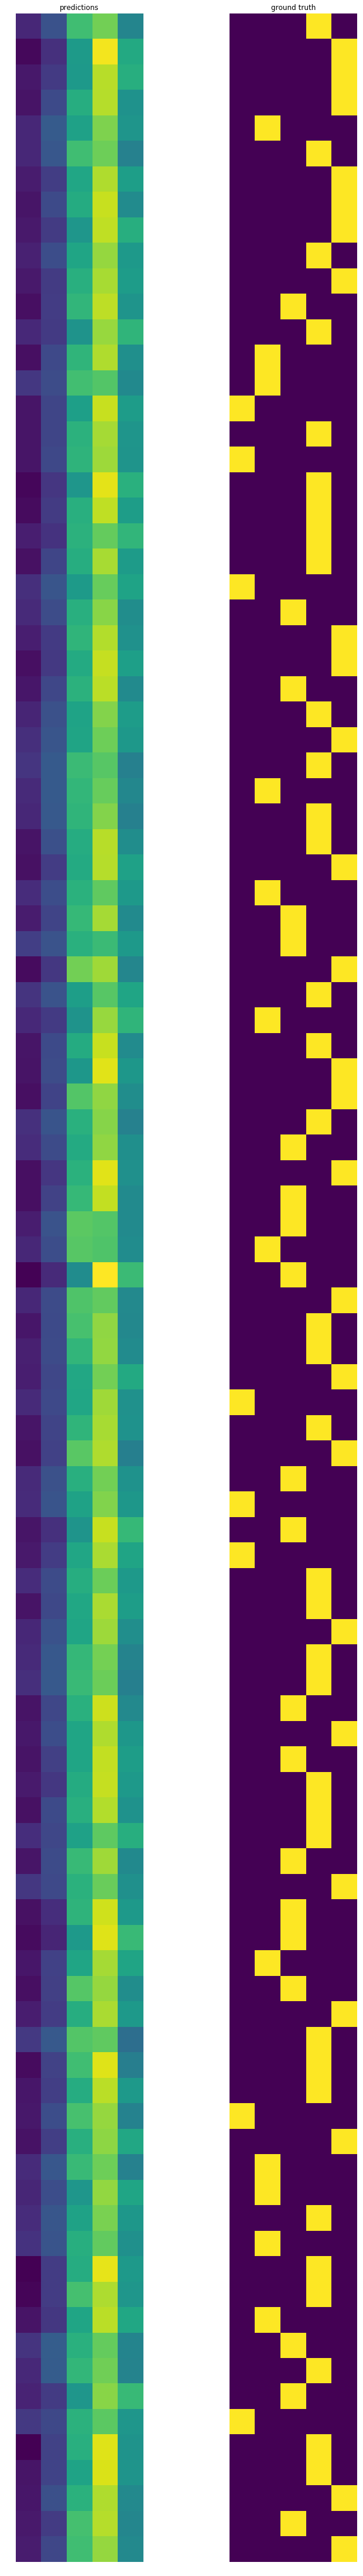

In [12]:
n = 100
plot_preds = list(probabilities)[:n]
plot_trgts = np.zeros([n, 5])
plot_trgts[np.arange(n), validset["rating"].iloc[:n].values-1] = 1

fig, axs = plt.subplots(1, 2, figsize=(12,80))
axs[0].set_title("predictions")
axs[1].set_title("ground truth")
axs[0].axis("off")
axs[1].axis("off")
axs[0].imshow(plot_preds)
axs[1].imshow(plot_trgts)
plt.show()